<a href="https://colab.research.google.com/github/zpalevani/StartUpFailure/blob/main/Startup_Failures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Question:** What types of startups are more likely to fail, and how do they cluster based on funding, sector, and reasons for failure?

Data Source: [Link](https://www.kaggle.com/datasets/dagloxkankwanda/startup-failures)

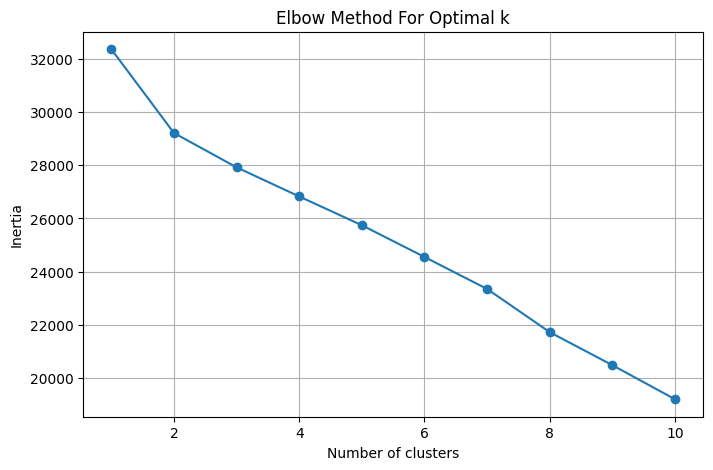

In [38]:
# Step 1: Clean & Preprocess
df = startup_df.copy()

# Drop irrelevant or unstructured columns
df = df.drop(columns=['Name', 'What They Did', 'Takeaway', 'Why They Failed', 'Years of Operation'])

# Clean 'How Much They Raised'
df['How Much They Raised'] = df['How Much They Raised'].str.replace(r'[^0-9.]', '', regex=True)

# Remove trailing periods to prevent conversion errors
df['How Much They Raised'] = df['How Much They Raised'].str.rstrip('.')
df['How Much They Raised'] = pd.to_numeric(df['How Much They Raised'], errors='coerce').fillna(0).astype(float)

# Fill missing values with 0 (or use another strategy)
df.fillna(0, inplace=True)

# One-hot encode 'Sector'
df = pd.get_dummies(df, columns=['Sector'], drop_first=True)

# Step 2: Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Step 3: Find Optimal k (Elbow Method)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


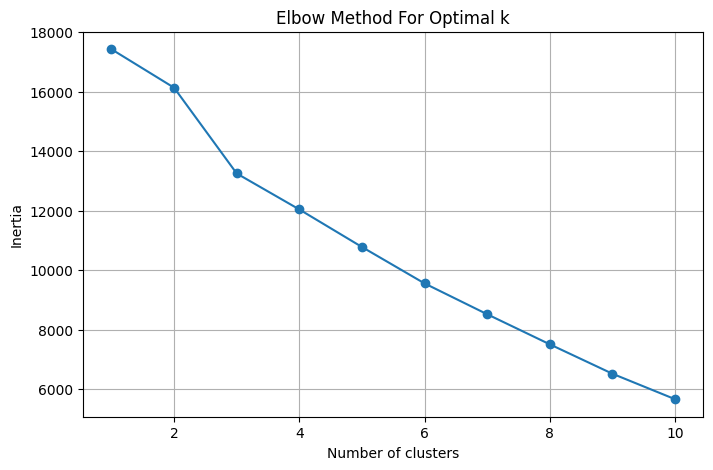

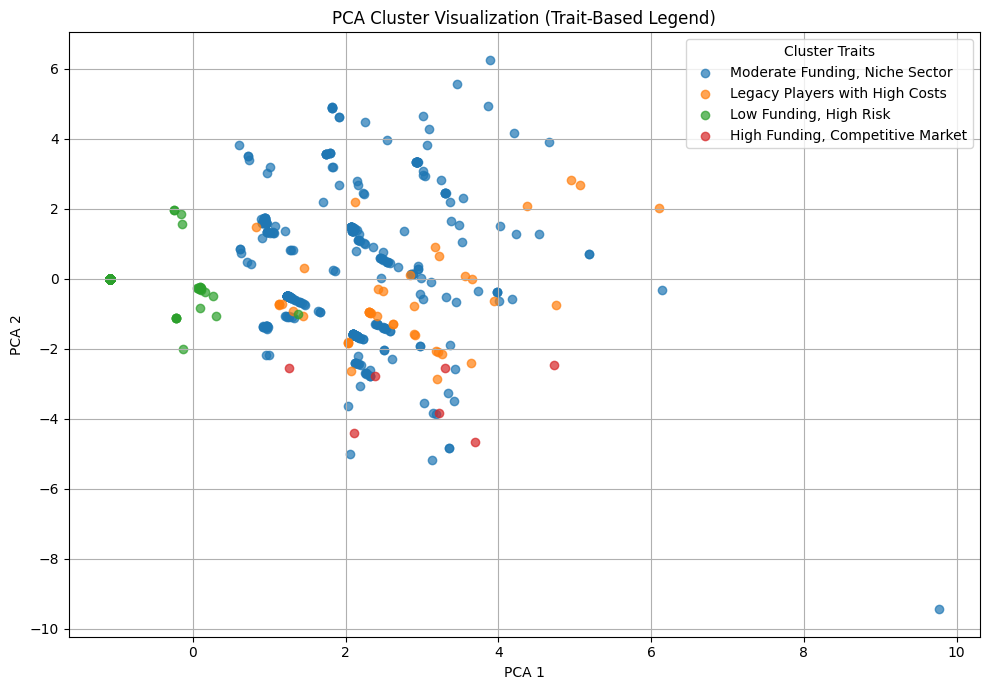

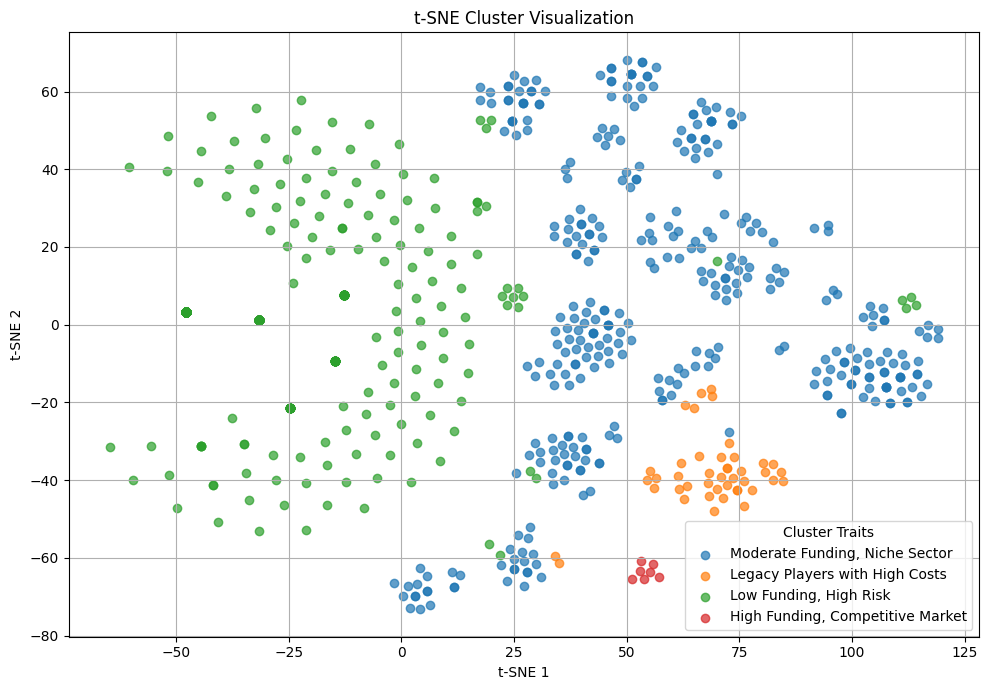


Cluster Centroid Profiles (Original Scale):


,How Much They Raised,Giants,No Budget,Competition,Poor Market Fit,Acquisition Stagnation,Platform Dependency,Monetization Failure,Niche Limits,Execution Flaws,Trend Shifts,Toxicity/Trust Issues,Regulatory Pressure,Overhype,Cluster_Label
0,1.78,0.00,0.00,0.01,0.00,0.00,-0.0,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,"Low Funding, High Risk"
1,144.36,1.00,0.29,0.43,0.00,0.43,1.0,0.00,0.00,0.14,0.14,0.14,0.00,-0.00,"High Funding, Competitive Market"
2,118.12,0.81,0.17,0.79,0.23,0.24,-0.0,0.14,0.21,0.15,0.00,0.06,0.05,0.04,"Moderate Funding, Niche Sector"
3,211.13,0.74,0.28,0.63,0.05,0.14,0.0,0.12,0.02,0.14,1.00,0.05,0.00,0.12,Legacy Players with High Costs



✅ Exported clustered_startups.csv


In [37]:
# 🚀 Startup Failure Clustering Project

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Step 2: Load and Combine All CSV Files
uploaded_files = [
    "/content/Startup Failure (Finance and Insurance).csv",
    "/content/Startup Failure (Finance and Insurance).csv",
    "/content/Startup Failure (Health Care).csv",
    "/content/Startup Failure (Manufactures).csv",
    "/content/Startup Failure (Retail Trade).csv",
    "/content/Startup Failures (Information Sector).csv",
    "/content/Startup Failures.csv"
]

# Combine into one DataFrame
df = pd.concat([pd.read_csv(file) for file in uploaded_files], ignore_index=True)

# Step 3: Clean and Preprocess
df['How Much They Raised'] = (
    df['How Much They Raised']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .str.replace(r'\.$', '', regex=True)
    .replace('', '0')
    .astype(float)
)
df.fillna(0, inplace=True)
df = pd.get_dummies(df.drop(columns=['Name', 'What They Did', 'Takeaway', 'Why They Failed', 'Years of Operation']),
                    columns=['Sector'], drop_first=True)

# Step 4: Scale Features
X = df.select_dtypes(include='number')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Elbow Method to Determine k
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Step 6: KMeans Clustering (k = 4)
kmeans_final = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Step 7: Assign Trait-Based Labels
cluster_labels = {
    0: 'Low Funding, High Risk',
    1: 'High Funding, Competitive Market',
    2: 'Moderate Funding, Niche Sector',
    3: 'Legacy Players with High Costs'
}
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# Step 8: PCA Plot
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
for label in df['Cluster_Label'].unique():
    mask = df['Cluster_Label'] == label
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=label, alpha=0.7)

plt.title('PCA Cluster Visualization (Trait-Based Legend)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster Traits')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: t-SNE Plot (optional, slower)
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_result = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
for label in df['Cluster_Label'].unique():
    mask = df['Cluster_Label'] == label
    plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], label=label, alpha=0.7)

plt.title('t-SNE Cluster Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster Traits')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Centroid Analysis
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids_original, columns=X.columns)
centroid_df['Cluster_Label'] = [cluster_labels[i] for i in range(4)]

print("\nCluster Centroid Profiles (Original Scale):")
display(centroid_df.round(2))

# Step 11: Save Clustered Data (Optional)
df.to_csv("clustered_startups.csv", index=False)
print("\n✅ Exported clustered_startups.csv")


# Segmentation Framework for stakholderss to prioritize support, anticipate failure risks, and design more tailored intervention programs for startup portolios. --->

# 🚀 Startup Failure Clustering Project

## Step 1: Import Libraries
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
```

## Step 2: Load and Combine All CSV Files
```python
uploaded_files = [
    "/mnt/data/Startup Failure (Finance and Insurance).csv",
    "/mnt/data/Startup Failure (Food and services).csv",
    "/mnt/data/Startup Failure (Health Care).csv",
    "/mnt/data/Startup Failure (Manufactures).csv",
    "/mnt/data/Startup Failure (Retail Trade).csv",
    "/mnt/data/Startup Failures (Information Sector).csv",
    "/mnt/data/Startup Failures.csv"
]

# Combine into one DataFrame
df = pd.concat([pd.read_csv(file) for file in uploaded_files], ignore_index=True)
```

## Step 3: Clean and Preprocess
```python
df['How Much They Raised'] = (
    df['How Much They Raised']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .str.replace(r'\.$', '', regex=True)
    .replace('', '0')
    .astype(float)
)
df.fillna(0, inplace=True)
df = pd.get_dummies(df.drop(columns=['Name', 'What They Did', 'Takeaway', 'Why They Failed', 'Years of Operation']),
                    columns=['Sector'], drop_first=True)
```

## Step 4: Scale Features
```python
X = df.select_dtypes(include='number')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```

## Step 5: Elbow Method to Determine k
```python
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()
```

## Step 6: KMeans Clustering (k = 4)
```python
kmeans_final = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)
```

## Step 7: Assign Trait-Based Labels
```python
cluster_labels = {
    0: 'Low Funding, High Risk',
    1: 'High Funding, Competitive Market',
    2: 'Moderate Funding, Niche Sector',
    3: 'Legacy Players with High Costs'
}
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)
```

## Step 8: PCA Plot
```python
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
for label in df['Cluster_Label'].unique():
    mask = df['Cluster_Label'] == label
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=label, alpha=0.7)

plt.title('PCA Cluster Visualization (Trait-Based Legend)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster Traits')
plt.grid(True)
plt.tight_layout()
plt.show()
```

## Step 9: t-SNE Plot (optional, slower)
```python
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_result = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
for label in df['Cluster_Label'].unique():
    mask = df['Cluster_Label'] == label
    plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], label=label, alpha=0.7)

plt.title('t-SNE Cluster Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster Traits')
plt.grid(True)
plt.tight_layout()
plt.show()
```

## Step 10: Centroid Analysis
```python
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids_original, columns=X.columns)
centroid_df['Cluster_Label'] = [cluster_labels[i] for i in range(4)]

print("\nCluster Centroid Profiles (Original Scale):")
display(centroid_df.round(2))
```

## Step 11: Save Clustered Data (Optional)
```python
df.to_csv("clustered_startups.csv", index=False)
print("\nExported clustered_startups.csv")
```

---

## Interpretation for VCs, Accelerators, or Incubators

### 1. There are 4 Distinct Failure Archetypes

Clustering revealed four distinct types of failed startups. Understanding these patterns allows VCs, incubators, and accelerators to assess risk and guide startups more effectively.

### High Funding, Competitive Market
- Substantial capital raised
- Failed due to competition, market saturation, or being out-executed
- Scaled quickly without long-term differentiation

**Implication:** High burn rates and aggressive growth must be matched with strong defensibility.

### Legacy Players with High Costs
- Heavy operational overhead
- Outdated business models or slow to adapt

**Implication:** Operational efficiency and innovation matter more than maturity or history.

### Moderate Funding, Niche Sector
- Mid-level funding in specialized markets
- Failure due to lack of scale or slow traction

**Implication:** These startups need more aggressive execution or stronger market validation to survive.

### Low Funding, High Risk
- Small or early-stage companies with limited capital
- Failed due to lack of resources and execution gaps

**Implication:** These are fragile ventures that need early, focused support and disciplined capital planning.
